In [43]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
sns.set(style="dark")
plt.rcParams.update({'font.size': 8})
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [44]:
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    print(d)
    print(mdev)
    print(mdev if mdev else 1.)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def pull_max(d):
    _rew = None
    new_mean = []
    for m in d:
        if _rew is None:
            _rew = m
        else:
            if m > _rew:
                _rew = m
        new_mean.append(_rew)
    return new_mean

def process_data(env_path, N=20 ):
    data = []
    mode_insert_data = []
    min_size = np.inf
    for path in glob.glob(env_path + '*/'):
        try: 
            data_set = pickle.load(open(path + 'reward_data.pkl', 'rb'))

            data_set = np.stack(data_set)
#             print(data_set[-1])
            if data_set[-1,0] < min_size:
                min_size = data_set[-1,0]
            data.append(data_set)
            has_mode_insert_data = False
        except:
            pass
        try:
            mode_insert_set = pickle.load(open(path + 'mode_insert_data.pkl', 'rb'))
            mode_insert_data.append([data_set[:-1,0], mode_insert_set])
            has_mode_insert_data = True
        except FileNotFoundError as err:
            pass
    x_samples = np.linspace(0, min_size, N)
    interp_data = []
    for data_set in data:
        _x = data_set[:,0]
#         _y = pull_max(data_set[:,1])
        _y = data_set[:,1]

        interp_data.append(np.interp(x_samples, _x, _y))
        
    mean = np.mean(interp_data, axis=0)
    std  = np.std(interp_data, axis=0)
    data_log = {'x' : x_samples, 'mean' : mean, 'std' : std, 
                'max' : np.max(interp_data, axis=0),
               'min' : np.min(interp_data, axis=0),
               '-std' : mean-std,
               '+std' : mean+std, 'data' : interp_data}
    
    if has_mode_insert_data:
        mi_interp_data = []
        for data_set in mode_insert_data:
            _x = data_set[0]
            _y = data_set[1]
            mi_interp_data.append(np.interp(x_samples, _x, _y))
        mi_mean = np.mean(mi_interp_data, axis=0)
        mi_max = np.max(mi_interp_data, axis=0)
        mi_min = np.min(mi_interp_data, axis=0)

        data_log.update({'mode_insert' : mi_mean,
                         'mi_min': mi_min,
                         'mi_max' : mi_max})

    return data_log

def plot_data(ax, log, label):
#     print(len(log['data']))
    ax.plot(log['x'], log['mean'], label=label)
#     ax.fill_between(log['x'], 
#                     log['min'], log['max'],
#                     alpha=0.2)
    ax.fill_between(log['x'], 
                    log['-std'], log['+std'],
                    alpha=0.2)


PendulumEnv (100, 1)
InvertedPendulumBulletEnv (100, 1)
HopperEnv (60, 1)
HalfCheetahEnv (60, 1)


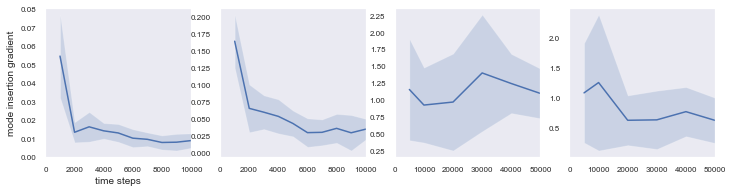

In [45]:
bullet = True
if bullet: 
    envs = ['PendulumEnv','InvertedPendulumBulletEnv','HopperEnv','HalfCheetahEnv']
    idx = 2
else: 
    envs = ['PendulumEnv','InvertedPendulumEnv','HopperEnv','HalfCheetahEnv']
    idx = 1

fig, axs = plt.subplots(1, 4, figsize=(12,2.75))
path_dir = '../data/hlt_deter/'
xs = [[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
      [5000, 10000, 20000, 30000, 40000, 50000]]

for i, env in enumerate(envs):
    got_data = False
    try: 
        data_path = path_dir + '{}/mig_log.pkl'.format(env)
        mig_data = pickle.load(open(data_path, 'rb'))
        got_data = True                
    except: 
        pass
    if got_data: 
        if i < idx : 
            x = xs[0]
        else: 
            x = xs[1]
        print(env,np.array(mig_data).shape)
        mig_mean= np.mean(np.array(mig_data).reshape(-1,len(x)), axis=0)
#         mig_min= np.min(np.array(mig_data).reshape(-1,len(x)), axis=0)
#         mig_max= np.max(np.array(mig_data).reshape(-1,len(x)), axis=0)
        mig_std = np.std(np.array(mig_data).reshape(-1,len(x)), axis=0)
        axs[i].plot(x,mig_mean)
        axs[i].fill_between(x, 
                    mig_mean-mig_std, mig_mean+mig_std,
                    alpha=0.2)
        axs[i].tick_params(axis='both', which='major', labelsize=8)

        axs[i].set_xlim([0,x[-1]])
#         axs[i].set_title(envs[i])
axs[0].set_ylabel('mode insertion gradient',fontsize=10)
axs[0].set_xlabel('time steps',fontsize=10)

if bullet: 
    plt.savefig('mujoco-mig-rerun_bullet.pdf')
else: 
    plt.savefig('mujoco-mig-rerun.pdf')
# axs[0].set_xlim(0, 20000)

hlt_deter
mpc_deter
sac__
hlt_stoch
mpc_stoch
sac__


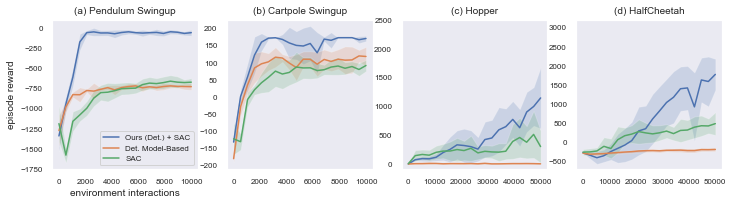

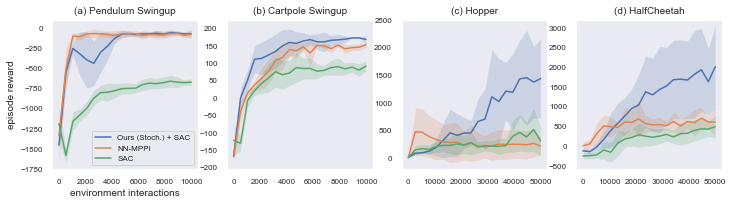

In [46]:
if bullet: 
    envs = ['PendulumEnv','InvertedPendulumBulletEnv','HopperEnv', 'HalfCheetahEnv'] 
    ylim = [100,225,2500,3200]
    file_names = ['mujoco-deter-rerun_bullet.pdf',
                  'mujoco-stoch-rerun_bullet.pdf']
else: 
    # envs = [ 'HopperBulletEnv', 'HalfCheetahEnv']
    envs = ['PendulumEnv','InvertedPendulumEnv','HopperEnv', 'HalfCheetahEnv'] 
    rew_max = [0,1000,3800,4800]
    max_frames = [10000,50000,50000,50000]
    ylim = [100,1200,2500,3200]
    file_names = ['mujoco-deter-rerun.pdf',
                  'mujoco-stoch-rerun.pdf']


methods_stoch = ['hlt_stoch','mpc_stoch','sac__']
methods_deter = ['hlt_deter','mpc_deter','sac__']
plot_legend_stoch = ['Ours (Stoch.) + SAC','NN-MPPI','SAC']
plot_legend_deter = ['Ours (Det.) + SAC','Det. Model-Based','SAC']
plot_titles = ['(a) Pendulum Swingup', '(b) Cartpole Swingup', '(c) Hopper', '(d) HalfCheetah']

for methods, plot_legend, save_name in zip([methods_deter,methods_stoch],
                                           [plot_legend_deter,plot_legend_stoch],
                                           file_names):
    fig, axs = plt.subplots(1, 4, figsize=(12,2.75))
    path_dir = '../data/'
    for method,lgd in zip(methods,plot_legend):
        for i, env in enumerate(envs):
            try:
                data_path = path_dir + '{}/{}/'.format(method, env)
                data = process_data(data_path)
                plot_data(axs[i], data, lgd)
#                 axs[i].hlines(rew_max[i],0,max_frames[i],ls='--')
                axs[i].set_title(plot_titles[i], fontsize=10)
#                 axs[i].set_xlabel('time steps', fontsize=10)
                axs[i].tick_params(axis='both', which='major', labelsize=8)
                if i == 1: 
                    print(method)
            except: 
                pass
    axs[0].set_ylabel('episode reward', fontsize=10)
    axs[0].legend(fontsize=8)
    axs[0].set_xlabel('environment interactions', fontsize=10)
    for i in range(4): 
        [ymin,_] = axs[i].get_ylim()
        axs[i].set_ylim([ymin,ylim[i]])
#     plt.show()
    plt.savefig(save_name)
    # axs[0].set_xlim(0, 20000)
    
# testing
# try: 
#     data_path = path_dir + '{}/{}/'.format('sac__', 'InvertedPendulumEnv_v1')
#     data = process_data(data_path)
#     plot_data(axs[1], data,'test')
#     data_path = path_dir + '{}/{}/'.format('sac__', 'InvertedPendulumEnv_v2')
#     data = process_data(data_path)
#     plot_data(axs[1], data,'test')
# except: 
#     pass